<strong>Aluno</strong>: Victor São Paulo Ruela



In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from timeit import default_timer as timer

from sklearn.metrics import mean_squared_error, roc_auc_score, accuracy_score, r2_score
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import load_boston
from sklearn.model_selection import KFold, StratifiedKFold

from tqdm import tqdm

import matplotlib.pyplot as plt
from pylab import cm
import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')


# Estudo do MLP para bases de dados multivariáveis

Neste trabalho é feita um estudo do algoritmo MLP para problemas de regressão e classificação multivariáveis. As bases de dados serão a [Boston Housing](https://archive.ics.uci.edu/ml/machine-learning-databases/housing/) e [Statlog (Heart)](https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/heart/), ambas disponíveis no repositório da UCI Machine Learning. 

Para cada base de dados, será feita uma análise do efeito dos seguintes parâmetros da arquitetura de uma rede MLP:

1. Função de ativação: serão avaliadas as funções logística, tangente hiperbólica e ReLU
2. Número de neurônios na camada escondida: considerando somente uma camada escondida, serão avaliados redes com 5, 500 e 5000 neurônios
3. Número de camadas escondidas: para um número fixo de 100 neurônios, será testada a rede com 1, 2 e 3 camadas escondidas

Será executa uma validação cruzada de 10 partições e os resultados de cada experimento serão comparados de acordo com a média da acurácia e erro quadrático médio (MSE).


In [2]:
# Carregamento das bases de dados
def load_heart_disease():
    data = pd.read_csv('heart.dat', sep=' ', header=None)
    data.dropna(inplace=True)
    data_np = data.to_numpy()
    X, y = data_np[:,:-1], data_np[:,-1]
    X = MinMaxScaler().fit_transform(X)
    y = pd.Series(y).map({1:-1,2:1}).to_numpy()
    return X,y

def load_boston_housing():
    X_bo, y_bo = load_boston(return_X_y = True)
    X_bo = MinMaxScaler().fit_transform(X_bo)
    y_bo = MinMaxScaler().fit_transform(y_bo.reshape(-1,1))
    
    return X_bo, y_bo.reshape(-1,)

In [3]:
X_bh, y_bh = load_boston_housing()
X_hd, y_hd = load_heart_disease()

In [4]:
# Definição dos modelos avaliados
models_activation = []
models_hidden_layer_size = []
models_number_layers = []

models_activation.append(('logistic', {'hidden_layer_sizes': (100,), 'activation': 'logistic' }))
models_activation.append(('tanh', {'hidden_layer_sizes': (100,), 'activation': 'tanh' }))
models_activation.append(('relu', {'hidden_layer_sizes': (100,), 'activation': 'relu' }))

models_hidden_layer_size.append(('5x1', {'hidden_layer_sizes': (5,), 'activation': 'relu' }))
models_hidden_layer_size.append(('500x1', {'hidden_layer_sizes': (500,), 'activation': 'relu' }))
models_hidden_layer_size.append(('5000x1', {'hidden_layer_sizes': (5000,), 'activation': 'relu' }))

models_number_layers.append(('100x2', {'hidden_layer_sizes': (100,100), 'activation': 'relu' }))
models_number_layers.append(('100x3', {'hidden_layer_sizes': (100,100,100), 'activation': 'relu' }))
models_number_layers.append(('100x4', {'hidden_layer_sizes': (100,100,100,100), 'activation': 'relu' }))

In [5]:
def plot_results(results, ylabel):
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.boxplot(data=results, x='Arquitetura', y=ylabel, ax=ax)
    fig.show()

def display_results_table(results, ylabel):
    display(results.groupby('Arquitetura')[ylabel].agg([np.mean, np.std]))

def run_cross_validation(X, y, mlp, scoring, models, ylabel):
    results = []
    kfold = KFold(10)
    for name, model_params in models:
        mlp.set_params(**model_params)
        fold = 1
        for train_index, test_index in kfold.split(X, y):
            # create the T and k dataset
            X_t, X_k = X[train_index, :], X[test_index, :]
            y_t, y_k = y[train_index], y[test_index]
            
            start = timer()
            mlp.fit(X_t, y_t)
            y_hat = mlp.predict(X_k)
            end = timer()
            elapsed = end - start

            score = scoring(y_k, y_hat)
            results.append((name, fold, score, elapsed))
            fold = fold + 1
    
    score_data = pd.DataFrame(results, columns=['Arquitetura', 'fold', ylabel, 'Tempo [s]'])
    plot_results(score_data, ylabel)
    display_results_table(score_data, ylabel)
    
    return score_data


## Boston Housing

### Função de Ativação

Os resultados deste experimento podem ser vistos abaixo, onde fica claro a influência da função utilizada. Embora as diferenças sejam muito pequenas entre o tangente hiperbólica e ReLU, nota-se que a função logística apresenta uma variabilidade muito maior.

,mean,std
Arquitetura,,
logistic,0.021646,0.015934
relu,0.014274,0.015084
tanh,0.017292,0.018124


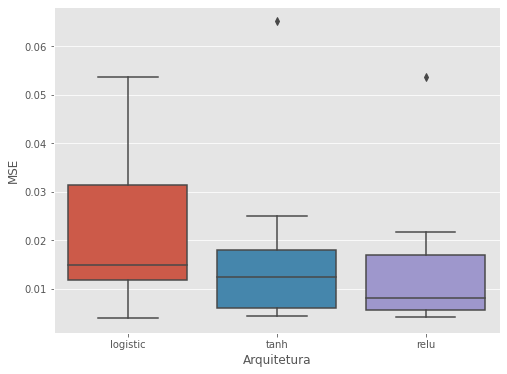

In [6]:
results_bh = run_cross_validation(X_bh, y_bh, MLPRegressor(), mean_squared_error, models_activation, 'MSE')

### Tamanho da camada escondida

Conforme os resultados abaixo, é possível notar que aumentando a complexidade do modelo, a qualidade da aproximação obtido será melhor. Isto está de acordo com o comportamento esperado. Destaca-se porém que para este problema em específico não foi observado o fenômeno de over-fitting, mesmo com 5000 neurônios na camada escondida.

,mean,std
Arquitetura,,
5000x1,0.010446,0.016498
500x1,0.011289,0.015091
5x1,0.050456,0.032212


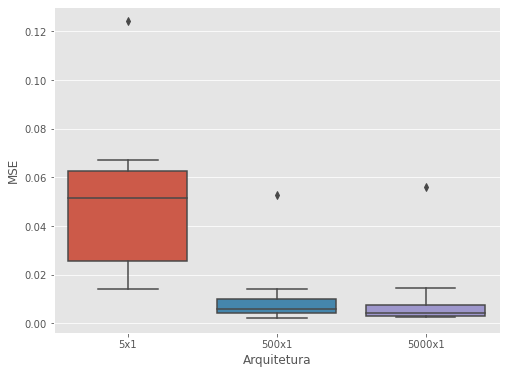

In [7]:
results_bh = run_cross_validation(X_bh, y_bh, MLPRegressor(), mean_squared_error, models_hidden_layer_size, 'MSE')

### Número de camadas escondidas

Através dos resultados abaixo, podemos notar que não houve muita diferença no MSE com o aumento da complexidade do modelo. Nota-se um leve aumento da métrica para 3 camadas, porém não podemos afirmar que isso é um reflexo de um possível aumento do over-fitting.

,mean,std
Arquitetura,,
100x2,0.011003,0.015385
100x3,0.011326,0.016629
100x4,0.011950,0.016604


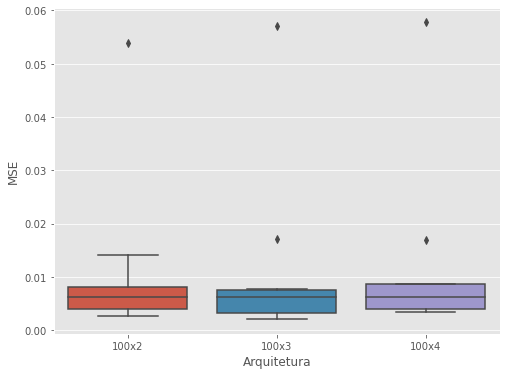

In [8]:
results_bh = run_cross_validation(X_bh, y_bh, MLPRegressor(), mean_squared_error, models_number_layers, 'MSE')

## Heart Disease
### Função de Ativação

Através dos resultados abaixo, é possível ver que a escolha de função de ativação exerceu pouca influência sobre esta base de dados. Entretanto, é interessante ressaltar que os resultados obtidos estão bem próximos dos obtidos para o ELM nos trabalhos anteriores, mesmo usando um número padrão de neurônios.

,mean,std
Arquitetura,,
logistic,83.703704,5.843042
relu,84.074074,3.923518
tanh,84.444444,3.825169


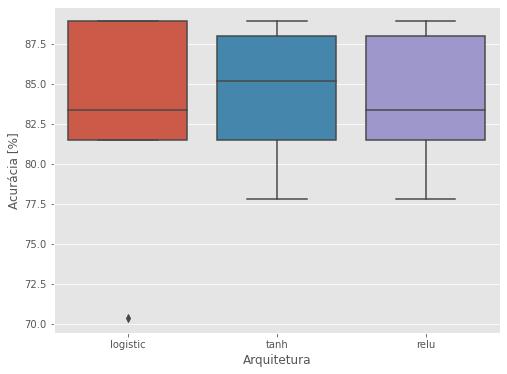

In [14]:
def accuracy_function(x,y):
    return 100 * accuracy_score(x,y)

results_hd = run_cross_validation(X_hd, y_hd, MLPClassifier(), accuracy_function, models_activation, 'Acurácia [%]')

### Tamanho da camada escondida

Conforme os resultados abaixo, é possível notar que aumentando a complexidade do modelo, começamos a observar um pouco de over-fitting. A tendência é que à medida em que aumentamos ainda mais sua complexidade, isso se torne mais acentuado. Vale ressaltar que foram obtidos resultados satisfatórios com somente 5 neurônios, embora o modelo seja bem simples.

,mean,std
Arquitetura,,
5000x1,81.111111,5.367177
500x1,84.074074,4.635798
5x1,79.629630,7.856742


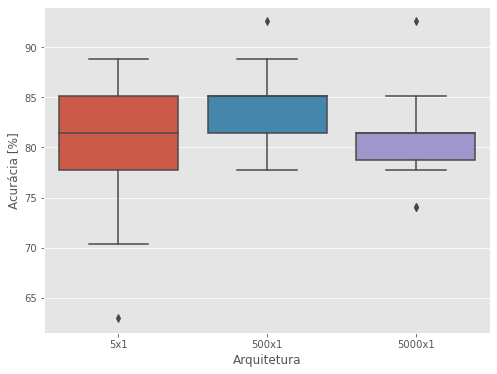

In [15]:
results_hd = run_cross_validation(X_hd, y_hd, MLPClassifier(), accuracy_function, models_hidden_layer_size, 'Acurácia [%]')

### Número de camadas escondidas

Através dos resultados abaixo, nota-se uma tendência de aumento da variabilidade do modelo com o aumento do número de camadas escondidas, o que está de acordo com o comportamento esperado. 

,mean,std
Arquitetura,,
100x2,80.000000,6.579216
100x3,78.148148,8.086184
100x4,79.259259,5.576094


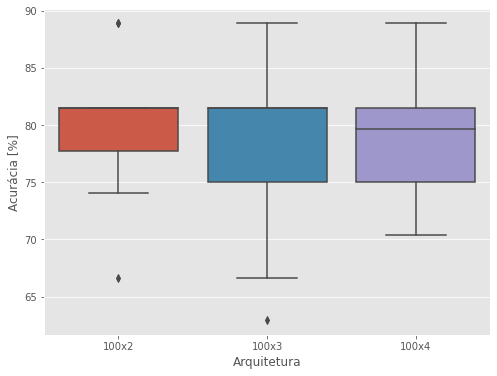

In [16]:
results_hd = run_cross_validation(X_hd, y_hd, MLPClassifier(), accuracy_function, models_number_layers, 'Acurácia [%]')

## Conclusão

Neste trabalho foi feito um estudo sobre alguns parâmetros das redes neurais MLP sobre problemas de regressão e classificação multivariáveis. Foi possível constatar que o controle de tais parâmetros não é uma tarefa fácil, devido a enorme quantidade de fatores que precisam ser ajustados. Os resultados mostraram que a escolha de qual função de ativação utilizar, bem como o tamanho e estrutura da rede são essenciais para se obter uma modelagem adequada.